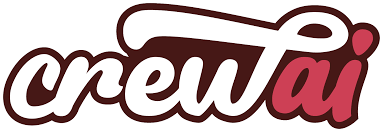

# Crew AI Demo - Mensagem de Marketing Customizada

- https://www.deeplearning.ai/short-courses/multi-ai-agent-systems-with-crewai/

Bilbiotecas necessárias para rodar esten notebook:
```Python
!pip install crewai==0.28.8 crewai_tools==0.1.6 langchain_community==0.0.29
```

- Necessário também obter uma API Key da Open AI e Serper
- [Open AI](https://openai.com/api)
- [Serper](https://serper.dev)

In [ ]:
import os
from utils import pretty_print_result
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# imports crew ai
from crewai import Agent, Task, Crew

In [ ]:
# import OpenAI
from openai import OpenAI

### modelo que vamos usar na OpenAI

In [ ]:
os.environ["OPENAI_MODEL_NAME"] = 'gpt-3.5-turbo'

### Chaves APIs (estão em arquivo texto para não serem apresentadas no código) 

In [ ]:
# Ler chaves APIs do arquivo texto
with open('api_keys.txt', 'r') as file:
    lines = file.readlines()
    openai_api_key = lines[0].strip()
    serper_api_key = lines[1].strip()

In [ ]:
os.environ["OPENAI_API_KEY"] = openai_api_key
os.environ["SERPER_API_KEY"] = serper_api_key

## Criação dos Agentes

In [ ]:
sales_rep_agent = Agent(
    role="Representante de Vendas",
    goal="Identificar leads de alto valor que correspondam "
         "ao nosso perfil de cliente ideal",
    backstory=(
        "Como parte da equipe de vendas dinâmica da CrewAI, "
        "sua missão é vasculhar "
        "o cenário digital em busca de leads potenciais. "
        "Armado com ferramentas de ponta "
        "e uma mentalidade estratégica, você analisa dados, "
        "tendências e interações para "
        "descobrir oportunidades que outros possam ter ignorado. "
        "Seu trabalho é crucial para abrir caminho "
        "para engajamentos significativos e impulsionar o crescimento da empresa."
    ),
    allow_delegation=False,
    verbose=True
)

In [ ]:
lead_sales_rep_agent = Agent(
    role="Representante de Vendas Principal",
    goal="Cultivar leads com comunicações personalizadas e atraentes",
    backstory=(
        "Dentro do vibrante ecossistema do departamento de vendas da CrewAI, "
        "você se destaca como a ponte entre clientes potenciais "
        "e as soluções de que eles precisam."
        "Ao criar mensagens envolventes e personalizadas, "
        "você não apenas informa os leads sobre nossas ofertas "
        "como também faz com que se sintam vistos e ouvidos."
        "Seu papel é fundamental para converter interesse "
        "em ação, guiando os leads na jornada "
        "da curiosidade ao compromisso."
    ),
    allow_delegation=False,
    verbose=True
)

## Criação das Ferramentas
### Ferramentas crewAI

- https://docs.crewai.com/core-concepts/Tools/#available-crewai-tools

In [ ]:
# ferramentas de leitura de diretório, leitura de arquivo e busca no Google
from crewai_tools import DirectoryReadTool, \
                         FileReadTool, \
                         SerperDevTool

In [ ]:
# instanciação das ferramentas
directory_read_tool = DirectoryReadTool(directory='./instructions')
file_read_tool = FileReadTool()
search_tool = SerperDevTool()

### Custom Tool
- Exemplo da criação de ferramenta customizada - [BaseTool](https://docs.crewai.com/core-concepts/Tools/#subclassing-basetool) class

In [ ]:
from crewai_tools import BaseTool

- Toda ferramenta precisa ter um `nome` e uma `descrição`.
- Para simplificação e fins didáticos, `SentimentAnalysisTool` retornará `positivo` para todo texto.
- Ao executar localmente, você pode personalizar o código com sua lógica na função `_run`.

In [ ]:
class SentimentAnalysisTool(BaseTool):
    name: str = "Ferramenta de Análise de Sentimento"
    description: str = ("Analisa o sentimento do texto "
                        "para garantir uma comunicação positiva e envolvente.")
    
    def _run(self, text: str) -> str:
        # Seu código personalizado da ferramenta vai aqui
        return "positivo"

In [ ]:
sentiment_analysis_tool = SentimentAnalysisTool()

## Criando Tasks / Atividades

A Tarefa de Perfilamento de Leads está usando as Ferramentas da crewAI.

In [ ]:
lead_profiling_task = Task(
    description=(
        "Conduza uma análise aprofundada de {lead_name}, "
        "uma empresa do setor de {industry} "
        "que recentemente demonstrou interesse em nossas soluções. "
        "Utilize todas as fontes de dados disponíveis "
        "para compilar um perfil detalhado, "
        "focando nos principais tomadores de decisão, "
        "desenvolvimentos recentes nos negócios "
        "e necessidades potenciais "
        "que se alinhem com nossas ofertas. "
        "Esta tarefa é crucial para personalizar "
        "nossa estratégia de engajamento de forma eficaz.\n"
        "Não faça suposições e "
        "use apenas informações das quais você tenha certeza absoluta."
    ),
    expected_output=(
        "Um relatório abrangente sobre {lead_name}, "
        "incluindo histórico da empresa, "
        "principais funcionários, marcos recentes e necessidades identificadas. "
        "Destaque áreas potenciais onde "
        "nossas soluções podem agregar valor, "
        "e sugira estratégias de engajamento personalizadas."
    ),
    tools=[directory_read_tool, file_read_tool, search_tool],
    agent=sales_rep_agent,
)


- A Tarefa de Alcance Personalizado está usando sua ferramenta personalizada `SentimentAnalysisTool`, bem como a `SerperDevTool` (search_tool) da crewAI.

In [ ]:
personalized_outreach_task = Task(
    description=(
        "Usando as percepções obtidas a partir "
        "do relatório de perfil do lead sobre {lead_name}, "
        "elabore uma campanha de alcance personalizada "
        "destinada a {key_decision_maker}, "
        "{position} de {lead_name}. "
        "A campanha deve abordar seu recente {milestone} "
        "e como nossas soluções podem apoiar seus objetivos. "
        "Sua comunicação deve ressoar "
        "com a cultura e os valores da empresa {lead_name}, "
        "demonstrando um profundo entendimento de "
        "seus negócios e necessidades.\n"
        "Não faça suposições e use apenas "
        "informações das quais você tenha certeza absoluta."
    ),
    expected_output=(
        "Uma série de rascunhos de e-mails personalizados, em português brasileiro, "
        "adaptados para {lead_name}, "
        "especificamente direcionados a {key_decision_maker}."
        "Cada rascunho deve incluir "
        "uma narrativa atraente que conecte nossas soluções "
        "com suas conquistas recentes e objetivos futuros. "
        "Garanta que o tom seja envolvente, profissional "
        "e alinhado com a identidade corporativa de {lead_name}. Dê destaque às informações levantadas, mostre a nossa pesquisa"
    ),
    tools=[sentiment_analysis_tool, search_tool],
    agent=lead_sales_rep_agent,
)

## Criando a "Crew"

In [ ]:
crew = Crew(
    agents=[sales_rep_agent, 
            lead_sales_rep_agent],
    
    tasks=[lead_profiling_task, 
           personalized_outreach_task],
	
    verbose=2,
	memory=True
)

## Rodando a Crew

In [ ]:
# preencher com os dados que deseja pesquisar
inputs = {
    "lead_name": "Banco ABCD",
    "industry": "Bancároa",
    "key_decision_maker": "José Silva",
    "position": "CEO",
    "milestone": "lançamento de produtos digitais"
}

result = crew.kickoff(inputs=inputs)

- Mostrar resultado como markdown

In [ ]:
from IPython.display import Markdown
Markdown(result)